En esta práctica, aprenderemos a utilizar diferentes tipos de redes neuronales para realizar el análisis de sentimiento del dataset de Multilingual Amazon Reviews Corpus.

# Análisis, preprocesamiento y preparación de los datos

In [ ]:
#Cargamos los datasets

from google.colab import drive

drive.mount('/content/drive')
amazon_en_train = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_train.csv'
amazon_en_dev = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_dev.csv'
amazon_en_test = '/content/drive/MyDrive/Máster NLP UR/amazon_dataset_en_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [ ]:
import pandas as pd

file_names = [(amazon_en_train, "train"), (amazon_en_dev, "dev"), (amazon_en_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name)
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

review_id          product_id          reviewer_id  stars  \
0     en_0964290  product_en_0740675  reviewer_en_0342986      1   
1     en_0690095  product_en_0440378  reviewer_en_0133349      1   
2     en_0311558  product_en_0399702  reviewer_en_0152034      1   
3     en_0044972  product_en_0444063  reviewer_en_0656967      1   
4     en_0784379  product_en_0139353  reviewer_en_0757638      1   
...          ...                 ...                  ...    ...   
4995  en_0681530  product_en_0198517  reviewer_en_0539725      5   
4996  en_0157408  product_en_0206198  reviewer_en_0605408      5   
4997  en_0542558  product_en_0525205  reviewer_en_0727937      5   
4998  en_0754850  product_en_0613095  reviewer_en_0643466      5   
4999  en_0843378  product_en_0323741  reviewer_en_0613446      5   

                                            review_body  \
0     Arrived broken. Manufacturer defect. Two of th...   
1     the cabinet dot were all detached from backing...   
2     I received my first order of this product and ...   
3     This product is a piece of shit. Do not buy. D...   
4     went through 3 in one day doesn't fit correct ...   
...                                                 ...   
4995  It's still early, but so far the scales seems ...   
4996  I’ve used this face mask a few times now and i...   
4997                         Great price. Good quality.   
4998  Fits my 2016 F150 XLT great. Now I dont have t...   
4999  Just what I needed! Perfect for western theme ...   

                                           review_title language  \
0     I'll spend twice the amount of time boxing up ...       en   
1                                          Not use able       en   
2                                  The product is junk.       en   
3                                Fucking waste of money       en   
4                                                bubble       en   
...                                                 ...      ...   
4995                                        Very sleek.       en   
4996  ... face mask a few times now and it works gre...       en   
4997                                         Five Stars       en   
4998                                      2016 F150 XLT       en   
4999                                           Perfect!       en   

      product_category  split  
0            furniture  train  
1     home_improvement  train  
2                 home  train  
3             wireless  train  
4                   pc  train  
...                ...    ...  
4995         drugstore   test  
4996            beauty   test  
4997              home   test  
4998        automotive   test  
4999           apparel   test  

[210000 rows x 9 columns]

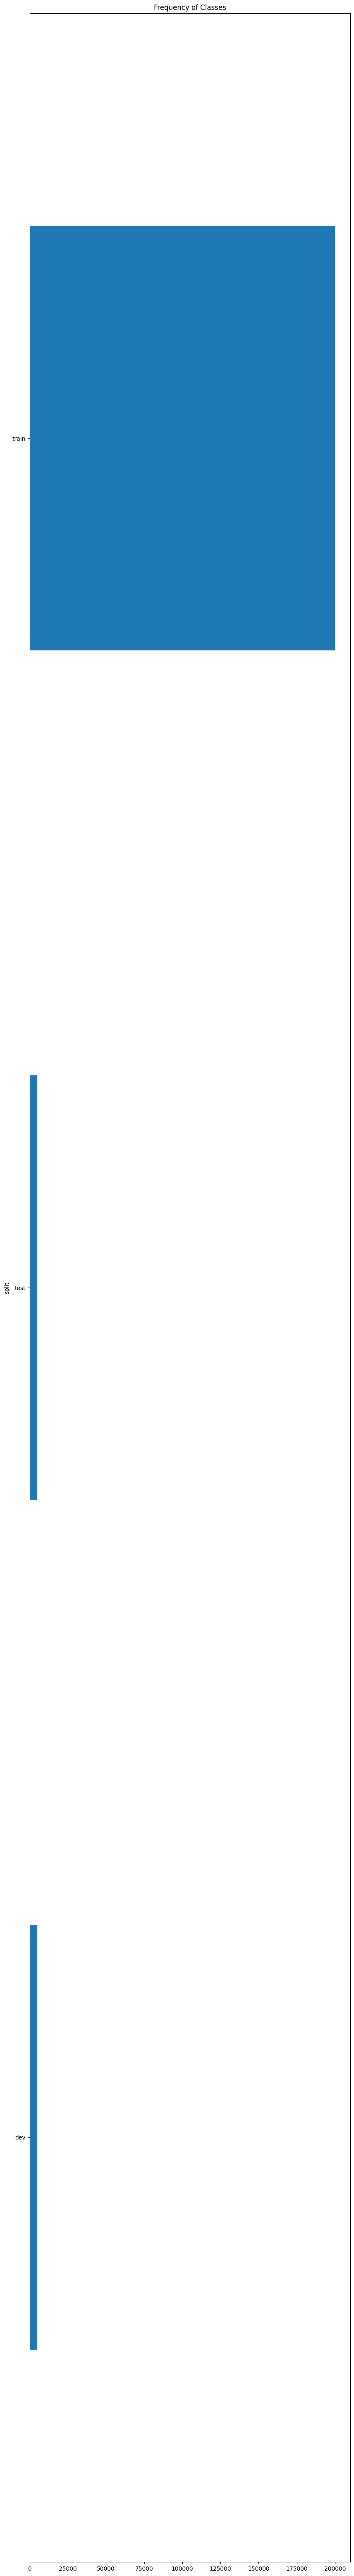

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

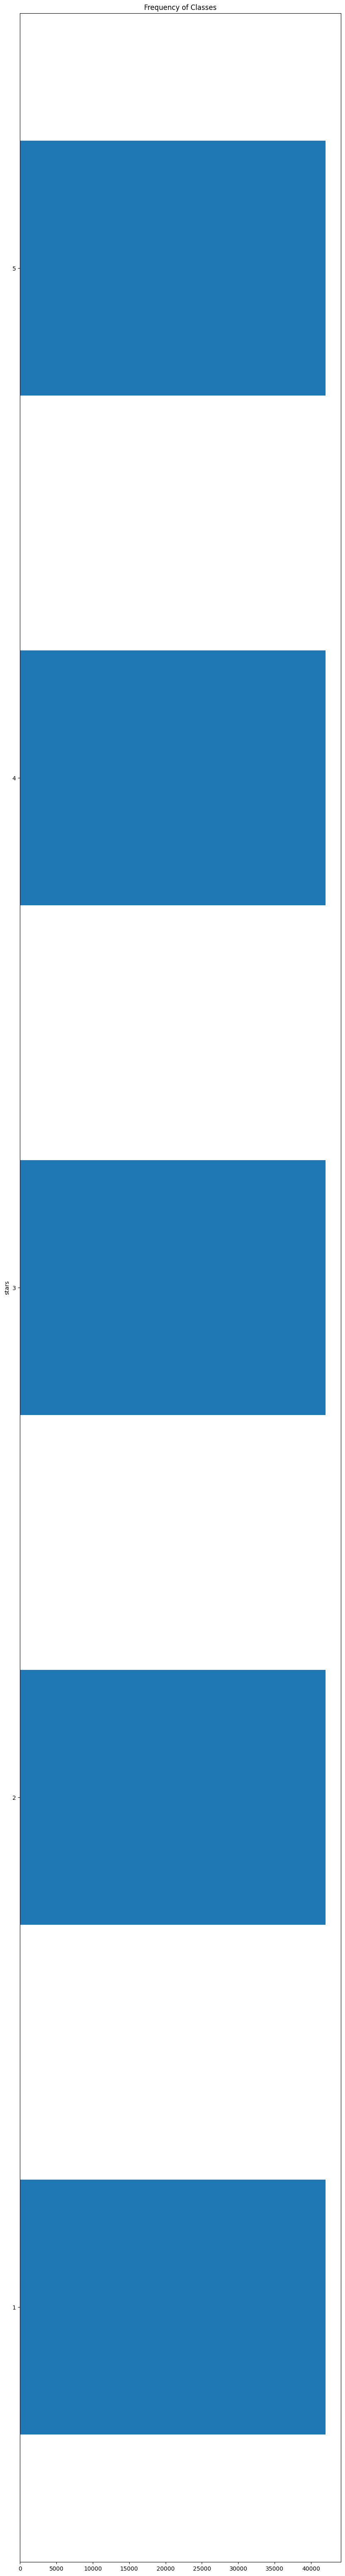

In [ ]:
# Distribucion de instancias por clases (i.e. estrellas)

df["stars"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Nos quedamos con las columnas que nos interesan
df = df[['review_body', 'stars', 'split']]
df

review_body  stars  split
0     Arrived broken. Manufacturer defect. Two of th...      1  train
1     the cabinet dot were all detached from backing...      1  train
2     I received my first order of this product and ...      1  train
3     This product is a piece of shit. Do not buy. D...      1  train
4     went through 3 in one day doesn't fit correct ...      1  train
...                                                 ...    ...    ...
4995  It's still early, but so far the scales seems ...      5   test
4996  I’ve used this face mask a few times now and i...      5   test
4997                         Great price. Good quality.      5   test
4998  Fits my 2016 F150 XLT great. Now I dont have t...      5   test
4999  Just what I needed! Perfect for western theme ...      5   test

[210000 rows x 3 columns]

Vamos a dividir nuevamente el dataframe en tres, uno por split, aleatorizar los conjuntos de datos, que estaban ordenados en función del número de estrellas.

In [ ]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

review_body  stars  split
17346   If you are using a DYMO printer don't waste yo...      1  train
6783                            the fruit arrived rotten!      1  train
2946            Came without USB cord, will be returning.      1  train
127503  It leaves a squeaky clean feeling which I don'...      4  train
38561   Several of the fish in our aquarium died withi...      1  train
...                                                   ...    ...    ...
45045   Won't stay charged and the circle you light th...      2  train
109881  Super cute. I will wear it, but the fabric is ...      3  train
28837   The replacement filter did not fit into the co...      1  train
1256         Did nothing for night glare. Waste of money.      1  train
50019   The color is beautiful, unfortunately when I w...      2  train

[200000 rows x 3 columns]

In [ ]:
X_train = df_train['review_body']
X_valid = df_valid['review_body']
X_test = df_test['review_body']

X_train

17346     If you are using a DYMO printer don't waste yo...
6783                              the fruit arrived rotten!
2946              Came without USB cord, will be returning.
127503    It leaves a squeaky clean feeling which I don'...
38561     Several of the fish in our aquarium died withi...
                                ...                        
45045     Won't stay charged and the circle you light th...
109881    Super cute. I will wear it, but the fabric is ...
28837     The replacement filter did not fit into the co...
1256           Did nothing for night glare. Waste of money.
50019     The color is beautiful, unfortunately when I w...
Name: review_body, Length: 200000, dtype: object

Vamos a realizar lo que se conoce como one-hot encoding, una técnica de preprocesamiento de datos que se utiliza a menudo en la creación de modelos de aprendizaje automático. Se utiliza para convertir variables categóricas, es decir, variables que solo pueden tomar un número limitado de valores discretos, como cadenas de texto, en formato numérico.

En este caso, se utiliza la clase LabelBinarizer de scikit-learn para realizar one-hot encoding en las etiquetas de entrenamiento, validación y prueba. Luego, se utilizan los métodos fit_transform y transform para ajustar el encoder a los datos de entrenamiento y luego transformar los datos de validación y prueba, respectivamente.

El método fit_transform ajusta el encoder a los datos de entrenamiento y luego realiza la transformación. El método transform, por otro lado, solo realiza la transformación utilizando el encoder ya ajustado.

Una vez que se han realizado los one-hot encoding, cada etiqueta se representa como un vector de ceros y unos, donde solo una posición del vector tiene un valor de uno y el resto tiene un valor de cero. Por ejemplo, si tenemos tres categorías, A, B y C, entonces la etiqueta A se representaría como [1, 0, 0], la etiqueta B como [0, 1, 0] y la etiqueta C como [0, 0, 1].

Una vez que se han realizado los one-hot encoding, se puede utilizar el conjunto de datos transformado para entrenar un modelo de redes neuronales con Keras.


In [ ]:
# One-hot encode the labels
from sklearn.preprocessing import LabelBinarizer

#encoder = LabelBinarizer()
#y_train = encoder.fit_transform(y_train)
#y_valid = encoder.transform(y_valid)
#y_test = encoder.transform(y_test)

In [ ]:
y_train = df_train['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_valid = df_valid['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_test = df_test['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_train

array([0, 0, 0, ..., 0, 0, 1])

# Entrenamiento de redes neuronales

En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

**Tokenización y preprocesamiento**

Propósito: Convertir texto en representación numérica que la red neuronal pueda procesar.
Proceso:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

    Tokenizer():
        Crea un diccionario que asigna cada palabra única a un índice numérico.
        Ejemplo: {"el": 1, "servicio": 2, "excelente": 3, ...}.
    fit_on_texts(X_train):
        Analiza todos los textos de entrenamiento para construir el vocabulario.
        Solo se hace con los datos de entrenamiento para evitar "fugas" de información.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq

[[39,
  25,
  24,
  133,
  6,
  13102,
  1135,
  97,
  295,
  85,
  59,
  2,
  350,
  19,
  1287,
  750,
  2106,
  1176,
  1069,
  63,
  31,
  365,
  282,
  2782,
  42,
  4,
  43,
  25,
  46,
  155,
  5,
  72,
  1,
  168,
  627,
  2106,
  20,
  365,
  282,
  339,
  147,
  16,
  1,
  1069,
  22,
  5,
  769,
  189,
  1177,
  559,
  154],
 [1, 2442, 196, 5911],
 [112, 228, 619, 572, 44, 28, 430],
 [3,
  865,
  6,
  6001,
  303,
  946,
  101,
  2,
  97,
  887,
  837,
  5,
  9098,
  1381,
  39,
  3095,
  371,
  87,
  3,
  1,
  319,
  7,
  60,
  31100,
  1,
  179,
  384,
  3,
  651,
  53,
  79,
  26,
  69,
  2175,
  639,
  101,
  2,
  102,
  11,
  6,
  580,
  10],
 [336,
  10,
  1,
  1600,
  14,
  190,
  4795,
  1113,
  377,
  15688,
  10,
  1514,
  9,
  152,
  130,
  1,
  130,
  7,
  420,
  13103,
  211,
  47,
  36,
  6,
  2274,
  4098,
  14,
  3,
  17,
  7,
  21,
  204,
  8,
  1600],
 [39,
  25,
  218,
  200,
  1,
  1163,
  69,
  4258,
  674,
  95,
  9,
  35,
  50,
  178,
  1670,
  43,
  2

In [ ]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'it': 3,
 'and': 4,
 'to': 5,
 'a': 6,
 'is': 7,
 'for': 8,
 'this': 9,
 'of': 10,
 'not': 11,
 'my': 12,
 'but': 13,
 'in': 14,
 'was': 15,
 'on': 16,
 'that': 17,
 'with': 18,
 'have': 19,
 'they': 20,
 'very': 21,
 'so': 22,
 'as': 23,
 'are': 24,
 'you': 25,
 'like': 26,
 'one': 27,
 'be': 28,
 'great': 29,
 'good': 30,
 'these': 31,
 'them': 32,
 'just': 33,
 'would': 34,
 'product': 35,
 'had': 36,
 'all': 37,
 'out': 38,
 'if': 39,
 'use': 40,
 'at': 41,
 'up': 42,
 'when': 43,
 'will': 44,
 'well': 45,
 'get': 46,
 'or': 47,
 'only': 48,
 'me': 49,
 'from': 50,
 'no': 51,
 'than': 52,
 'too': 53,
 'work': 54,
 'after': 55,
 'really': 56,
 "it's": 57,
 'more': 58,
 'time': 59,
 'what': 60,
 'off': 61,
 'were': 62,
 'because': 63,
 'quality': 64,
 'love': 65,
 'can': 66,
 'has': 67,
 'do': 68,
 'an': 69,
 'little': 70,
 'fit': 71,
 'about': 72,
 'did': 73,
 'bought': 74,
 'nice': 75,
 'we': 76,
 'other': 77,
 'does': 78,
 'much': 79,
 'works': 80,
 'even': 81

**Creación de secuencias y padding**

Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 120. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 120 tokens.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 120. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 120

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_valid_pad = pad_sequences(X_valid_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

X_train_pad

array([[  39,   25,   24, ...,    0,    0,    0],
       [   1, 2442,  196, ...,    0,    0,    0],
       [ 112,  228,  619, ...,    0,    0,    0],
       ...,
       [   1,  323,  872, ...,    0,    0,    0],
       [  73,  280,    8, ...,    0,    0,    0],
       [   1,  146,    7, ...,    0,    0,    0]], dtype=int32)

**Reutilización de una matriz de embeddings pre-entrenada (opcional)**

Propósito: Utilizar embeddings pre-entrenados (GloVe) para dar significado semántico a las palabras.


In [ ]:
#ruta_glove = '/content/drive/MyDrive/Máster NLP UR/glove.6B.100d.txt'

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    ruta_glove,
    tokenizer.word_index,
    embedding_dim)

# Veamos el porcentaje de vocabulario cubierto
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7891050083543978

## Red neuronal RNN básica

**Opción 1: Uso del último estado oculto**

En este caso, la RNN procesa el texto y se utiliza el estado oculto del último token hn como resumen. Luego, este vector se pasa a una red feedforward (capa densa) que, mediante una función softmax, genera la probabilidad de cada clase.

In [ ]:
# Modelo simplificado para clasificación de sentimientos (1 a 5 estrellas)
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Por ejemplo, 5 categorías de sentimiento (1 a 5 estrellas)

model_basic = Sequential([
    # Capa de Embedding: Transforma índices de palabras en vectores densos.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia y devuelve solo el último estado oculto del último token.
    # Teóricamente, se basa en la actualización h_t = g(U*h_{t-1} + W*x_t).
    SimpleRNN(128, return_sequences=False),

    # Capa de clasificación (salida): Una red feedforward que toma h_n y genera la probabilidad para cada clase.
    Dense(num_classes, activation='softmax')
])

model_basic.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_basic.summary()

# Compilación del modelo:
# - Se usa el optimizador 'adam' para ajustar la tasa de aprendizaje dinámicamente.
# - La función de pérdida 'sparse_categorical_crossentropy' es adecuada para etiquetas enteras.
model_basic.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_basic.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Conexión teoría-práctica**:

- Teoría: Cada palabra se procesa y el estado oculto se actualiza según la fórmula ht=g(Uht−1+Wxt)ht​=g(Uht−1​+Wxt​). El último estado hn​ resume la información de toda la secuencia.
- Práctica: En el código, SimpleRNN con return_sequences=False devuelve directamente hn​, que se utiliza en la capa densa para realizar la clasificación final mediante softmax.

**Opción 2: Uso de Pooling sobre todos los estados ocultos**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(num_classes, activation='softmax')
])

model_pool.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

En ambas opciones, la red se entrena de forma end-to-end. El error generado en la salida softmax se retropropaga a través del clasificador y la RNN, ajustando los pesos (W, U y V) conforme a la función de pérdida (entropía cruzada). Esto permite que el modelo aprenda a transformar de manera óptima la secuencia en una predicción de clase.

Este tipo de arquitectura es ampliamente utilizado en tareas como el análisis de sentimientos, detección de spam y clasificación temática de documentos. La elección entre usar hn o un pooling sobre todos los estados dependerá de la naturaleza de los datos y de la importancia de capturar información de toda la secuencia frente a la relevancia del final de la misma.

## RNNs apiladas (Stacked RNNs)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Parámetros del modelo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Número de clases, por ejemplo, 5 categorías para sentimientos (1 a 5 estrellas)

# Modelo con RNNs apiladas
model_stacked = Sequential([
    # Capa de Embedding:
    # Transforma índices de palabras en vectores densos que capturan similitudes semánticas.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Primera capa RNN:
    # Se procesa la secuencia palabra a palabra y se devuelve la secuencia completa
    # (return_sequences=True) para que la siguiente capa RNN pueda procesar cada paso.
    # Teóricamente, cada actualización se basa en h_t = g(U * h_{t-1} + W * x_t).
    SimpleRNN(128,
              return_sequences=True,
              dropout=0.2,            # Regularización para evitar sobreajuste
              recurrent_dropout=0.2),

    # Segunda capa RNN:
    # Toma la secuencia de salidas de la primera capa y genera un vector resumen de toda la secuencia.
    # Al configurar return_sequences=False, solo se obtiene el estado oculto del último token, h_n,
    # que resume la información procesada.
    SimpleRNN(64,
              return_sequences=False,
              dropout=0.2,
              recurrent_dropout=0.2),

    # Capa Densa intermedia:
    # Funciona como un clasificador que transforma la representación del texto (h_n) en características de alto nivel.
    Dense(64, activation='relu'),

    # Capa de salida:
    # La función softmax genera una distribución de probabilidad sobre las 5 clases.
    Dense(num_classes, activation='softmax')
])

# Compilación del modelo:
# - Optimizer 'adam' ajusta la tasa de aprendizaje dinámicamente.
# - La función de pérdida 'sparse_categorical_crossentropy' se utiliza para etiquetas enteras.
model_stacked.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model_stacked.summary()


**Conexión entre teoría y práctica**

    Capa de Embedding:
        Teoría: Se transforma cada palabra (representada por un índice) en un vector denso que refleja relaciones semánticas, facilitando la posterior extracción de características.
        Práctica: La capa Embedding convierte el input en vectores de 100 dimensiones, sirviendo de punto de partida para el procesamiento secuencial.

    Primer RNN (SimpleRNN con return_sequences=True):
        Teoría: Según la fórmula ht=g(Uht−1+Wxt)ht​=g(Uht−1​+Wxt​), la red actualiza su estado oculto en cada paso, y al devolver toda la secuencia (todos los htht​) se permite que la siguiente capa acceda a todas estas representaciones intermedias.
        Práctica: La primera capa RNN procesa cada token y devuelve una secuencia completa de estados ocultos, lo que posibilita una abstracción inicial de la información.

    Segunda RNN (SimpleRNN con return_sequences=False):
        Teoría: La salida de una capa RNN se puede utilizar como entrada para otra RNN, permitiendo que la red capture representaciones en distintos niveles de abstracción. El estado oculto final hnhn​ resume la información relevante de la secuencia.
        Práctica: La segunda capa RNN recibe la secuencia completa de la capa anterior y, configurada para devolver solo el último estado, genera un vector resumen de la secuencia (h_n).

    Capas Densas y Clasificación:
        Teoría: Una vez que se ha obtenido una representación global de la secuencia (por ejemplo, hnhn​), se puede pasar a una red feedforward que actúa como clasificador.
        Práctica: La capa Dense con activación ReLU transforma la representación en características de alto nivel, y la capa final con softmax asigna probabilidades a cada una de las 5 clases, completando la tarea de clasificación.

    Entrenamiento End-to-End:
        Teoría: La red se entrena de manera end-to-end, propagando el error desde la capa de salida hacia las capas anteriores (incluyendo las RNN apiladas), lo que permite ajustar todos los pesos en función de la tarea de clasificación.
        Práctica: El uso de sparse_categorical_crossentropy y el optimizador adam facilitan la convergencia del modelo durante el entrenamiento.

En las capas apiladas hemos usado dropout, una técnica de regularización que se utiliza para reducir el sobreajuste en las redes neuronales. Durante el entrenamiento, "apaga" aleatoriamente (pone a cero) un porcentaje de las activaciones de una capa, lo que obliga a la red a aprender representaciones más robustas. Esto significa que la red no depende exclusivamente de un pequeño conjunto de neuronas, promoviendo así la generalización en datos no vistos.

¿Por qué se usa en las RNNs apiladas?

- A mayor profundidad, mayor Riesgo de Sobreajuste: Al apilar múltiples capas RNN, el modelo se vuelve más complejo y tiene más parámetros, lo que incrementa el riesgo de que se ajuste demasiado a los datos de entrenamiento.
- Mejora la robustez: Dropout (y el recurrent_dropout en el caso de las conexiones recurrentes) ayuda a que cada capa no dependa excesivamente de la salida de la capa anterior, promoviendo una mejor propagación de información a través de la red.
- No es estrictamente necesario, pero suele ser beneficioso en la práctica para evitar que la red "memorice" los datos de entrenamiento, lo que se traduce en una mejor capacidad de generalización en aplicaciones reales.


## RNNs bidireccionales apiladas (Stacked Bidirectional RNNs)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense

# Parámetros del modelo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings
num_classes = 5                              # Número de categorías (por ejemplo, 5 estrellas)

# Modelo con RNNs bidireccionales apiladas
model_bidirectional = Sequential([
    # Capa de Embedding:
    # Transforma cada palabra (índice) en un vector denso que captura sus relaciones semánticas.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Primera capa RNN Bidireccional:
    # Esta capa procesa la secuencia en dos direcciones:
    #  - La pasada directa (left-to-right) genera hf_t = RNN_forward(x1, ..., xt)
    #  - La pasada inversa (right-to-left) genera hb_t = RNN_backward(xt, ..., xn)
    # Al establecer return_sequences=True se devuelve la secuencia completa de estados de cada dirección,
    # permitiendo que la siguiente capa pueda seguir procesando la información a nivel de cada token.
    Bidirectional(SimpleRNN(128,
                            return_sequences=True,
                            dropout=0.2,
                            recurrent_dropout=0.2)),

    # Segunda capa RNN Bidireccional:
    # Toma como entrada la secuencia completa de la capa anterior y, al configurar return_sequences=False,
    # extrae el estado oculto final de cada dirección.
    # Esto produce dos vectores: uno que resume el contexto desde el inicio hasta el final (forward)
    # y otro que resume desde el final hasta el inicio (backward). Se concatenan para formar la representación final.
    Bidirectional(SimpleRNN(64,
                            return_sequences=False,
                            dropout=0.2,
                            recurrent_dropout=0.2)),

    # Capas Densas:
    # Convierten la representación combinada [hf_n; hb_n] en una clasificación final mediante una red feedforward.
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compilación del modelo:
# - 'adam' ajusta la tasa de aprendizaje de forma dinámica.
# - 'sparse_categorical_crossentropy' mide la discrepancia entre la predicción y la etiqueta real.
model_bidirectional.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

model_bidirectional.summary()

#Embedding(input_dim=vocab_size,
 #             output_dim=embedding_dim,
  #            weights=[embedding_matrix], # Usa matriz pre-entrenada
   #           input_length=maxlen,
    #          trainable=True) # Se reentrenan los embeddings

**Conexión teoría-práctica:**

    Procesamiento Bidireccional:

        Teoría:
        La RNN directa procesa la secuencia de izquierda a derecha, acumulando información de los tokens anteriores. Su estado en el tiempo tt es htf=RNNforward(x1,…,xt)htf​=RNNforward​(x1​,…,xt​).
        La RNN inversa, procesando la secuencia de derecha a izquierda, genera el estado htb=RNNbackward(xt,…,xn)htb​=RNNbackward​(xt​,…,xn​).
        Al concatenar ht=[htf;htb]ht​=[htf​;htb​] se obtiene una representación que incluye tanto el contexto previo como el posterior, mejorando la comprensión del significado del token actual.

        Práctica:
        El envoltorio Bidirectional en Keras implementa este concepto automáticamente. Al usar return_sequences=True en la primera capa, se devuelve la secuencia completa de estados de ambas direcciones para cada token. En la segunda capa, al configurar return_sequences=False, se obtienen los estados finales de ambas pasadas, los cuales se concatenan y se usan para la clasificación.

    Representación Final para Clasificación:
        Teoría:
        Para tareas de clasificación de secuencias, se utiliza la representación del final del proceso (por ejemplo, la concatenación de hnfhnf​ y h1bh1b​) como resumen de toda la secuencia.
        Práctica:
        El modelo extrae esta representación combinada y la pasa a capas densas, que actúan como clasificador mediante la función softmax para asignar probabilidades a cada clase.

    Entrenamiento End-to-End:
        Teoría:
        El error derivado de la clasificación se propaga a través de la red completa, ajustando tanto las RNNs bidireccionales como las capas densas.
        Práctica:
        La compilación con sparse_categorical_crossentropy y el optimizador adam permite entrenar la red de forma end-to-end, ajustando todos los pesos en función del error obtenido en la salida.

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento. Esta función toma varios argumentos:

    X_train: es una matriz de tamaño (num_ejemplos, longitud_secuencia) con los ejemplos de entrenamiento.
    y_train: es una matriz de tamaño (num_ejemplos, num_clases) con las etiquetas de clase correspondientes a los ejemplos de entrenamiento.
    batch_size: es el tamaño del batch de ejemplos que se utilizará para entrenar el modelo. El tamaño del batch influye en la velocidad de entrenamiento y en la precisión del modelo.
    epochs: es el número de veces que se iterará sobre los datos de entrenamiento.
    validation_data: es una tupla con los datos de validación y las etiquetas de clase correspondientes. Estos datos se utilizan para evaluar el modelo después de cada epoch y para detener el entrenamiento si no mejora.

La función fit devuelve un objeto history con información sobre el entrenamiento del modelo, como las pérdidas y las métricas de entrenamiento y validación en cada epoch. Esta información puede ser útil para evaluar el rendimiento del modelo y para ajustar sus hiperparámetros.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_basic.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 208s 525ms/step - accuracy: 0.2856 - loss: 1.5254 - val_accuracy: 0.3896 - val_loss: 1.4085
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 223s 427ms/step - accuracy: 0.3403 - loss: 1.4595 - val_accuracy: 0.3024 - val_loss: 1.5511
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 226s 489ms/step - accuracy: 0.3719 - loss: 1.4195 - val_accuracy: 0.3716 - val_loss: 1.4313
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 184s 441ms/step - accuracy: 0.4002 - loss: 1.3533 - val_accuracy: 0.3940 - val_loss: 1.3649
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 184s 470ms/step - accuracy: 0.4281 - loss: 1.2920 - val_accuracy: 0.4072 - val_loss: 1.3429


In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 204s 509ms/step - accuracy: 0.2884 - loss: 1.5387 - val_accuracy: 0.2970 - val_loss: 1.5181
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 218s 551ms/step - accuracy: 0.3124 - loss: 1.5434 - val_accuracy: 0.4384 - val_loss: 1.3829
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 234s 478ms/step - accuracy: 0.4709 - loss: 1.3054 - val_accuracy: 0.4682 - val_loss: 1.2594
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 202s 478ms/step - accuracy: 0.5129 - loss: 1.1797 - val_accuracy: 0.4804 - val_loss: 1.2363
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 188s 481ms/step - accuracy: 0.5372 - loss: 1.1117 - val_accuracy: 0.5000 - val_loss: 1.1985


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4883 - loss: 1.2018

Precisión en test: 0.4956


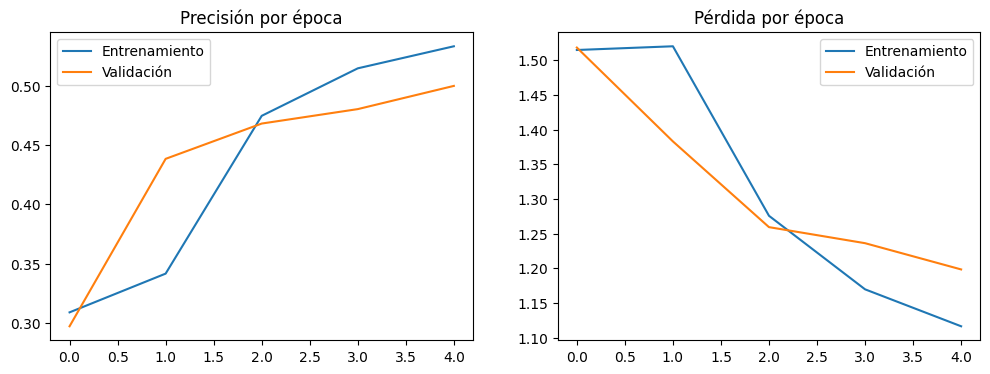

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


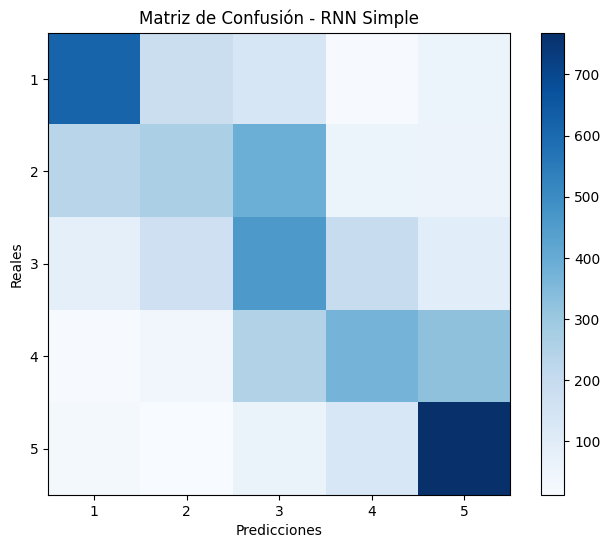

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_pool.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.63      0.62      0.62      1000
          2★       0.40      0.27      0.32      1000
          3★       0.35      0.46      0.40      1000
          4★       0.48      0.37      0.42      1000
          5★       0.59      0.77      0.67      1000

    accuracy                           0.50      5000
   macro avg       0.49      0.50      0.49      5000
weighted avg       0.49      0.50      0.49      5000



In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=44026b7104544fe5b2a19f77583bb3ea781912d671bf8962dca012068c3cbaaf
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime.lime_text import LimeTextExplainer
# Función de predicción para LIME
def predict_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return model_pool.predict(padded)

# Crear explicador
explainer = LimeTextExplainer(class_names=['1★', '2★', '3★', '4★', '5★'])

# Explicar una predicción
idx = 0  # Índice del ejemplo a explicar
exp = explainer.explain_instance(X_test[idx], predict_lime, num_features=10, top_labels=2)

# Mostrar explicación
exp.show_in_notebook(text=X_test[idx])

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


In [ ]:
df_test['pred'] = y_pred + 1
df_test.head(10)

review_body  stars split  pred
1154             I received wrong color and wrong size.      2  test     0
168   The book was hard to keep up with as it jumped...      1  test     2
93    Terrible product ! Came with moldy batteries A...      1  test     0
2808  Lots of lines, not easy to color. Definitely n...      3  test     2
1453  I bought 2 of these for my 2 new iPhone 8s and...      2  test     2
1732  I had been wanting this wallet for a long time...      2  test     1
3124  These are okay headphones, they are what I exp...      4  test     3
2767  Pretty but cheaply made. Broke first time I pu...      3  test     2
253   The graphics were not centered and placed more...      1  test     1
1564  First of all I'd like to know who got the devi...      2  test     2

### Inclusión de características léxicas en el modelo de RNN

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet as wn, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
# Descargar recursos necesarios de NLTK (si no se han descargado antes)
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger_eng')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    """
    Convierte etiquetas del PennTreebank en etiquetas de WordNet.
    - 'J' -> Adjetivo (wn.ADJ)
    - 'N' -> Sustantivo (wn.NOUN)
    - 'R' -> Adverbio (wn.ADV)
    - 'V' -> Verbo (wn.VERB)
    Si no coincide, devuelve None.
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_lex_features(text):
  tokens = word_tokenize(text)
  pos_tagged = nltk.pos_tag(tokens)
  sentiment_sum = 0.0
  for word, tag in pos_tagged:
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
      continue
    lemma = lemmatizer.lemmatize(word.lower(), wn_tag)
    synsets = list(swn.senti_synsets(lemma, wn_tag))
    if not synsets:
      continue
    # Cálculo de scores
    pos = sum(synset.pos_score() for synset in synsets)
    neg= sum(synset.neg_score() for synset in synsets)
    sentiment_score = pos - neg
    sentiment_sum += sentiment_score
  return sentiment_sum

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, GlobalAveragePooling1D, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parámetros del modelo
embedding_dim = 100                          # Dimensión de los embeddings
maxlen = 120                                 # Longitud máxima de la secuencia
num_classes = 5                              # Por ejemplo, 5 categorías (1 a 5 estrellas)
num_lex_features = 1                         # Ejemplo: [conteo_positivo, conteo_negativo, conteo_neutro]. Alternativamente, si solo usas un score, num_lex_features = 1

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['review_body'])

In [ ]:
def prepare_inputs(texts, tokenizer, maxlen):
    """
    Convierte una lista de textos en secuencias numéricas (pad_sequences)
    y calcula las características léxicas para cada texto.
    Retorna dos arrays: uno para la secuencia y otro para las características léxicas.
    """
    # Convertir textos a secuencias de índices
    sequences = tokenizer.texts_to_sequences(texts)
    X_text = pad_sequences(sequences, maxlen=maxlen, padding='post')

    # Extraer características léxicas para cada texto
    X_lex = np.array([get_lex_features(text) for text in texts])

    # Obtener el tamaño del vocabulario
    vocab_size = len(tokenizer.word_index) + 1

    return X_text, X_lex, vocab_size

In [ ]:
df_train_pad, df_train_lex, vocab_size = prepare_inputs(df_train['review_body'], tokenizer, maxlen)
df_valid_pad, df_valid_lex, _ = prepare_inputs(df_valid['review_body'], tokenizer, maxlen)
df_test_pad, df_test_lex, _ = prepare_inputs(df_test['review_body'], tokenizer, maxlen)

In [ ]:
df_test_pad

array([[ 48,  87,   8, ...,   0,   0,   0],
       [ 20,  62, 348, ...,   0,   0,   0],
       [ 76,  74,   3, ...,   0,   0,   0],
       ...,
       [  2,  56,  26, ...,   0,   0,   0],
       [ 75, 146,  13, ...,   0,   0,   0],
       [  2,  73, 952, ...,   0,   0,   0]], dtype=int32)

In [ ]:
y_train = df_train['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_valid = df_valid['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_test = df_test['stars'].map({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_train

array([1, 1, 0, ..., 2, 2, 3])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, GlobalAveragePooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

#############################################
# 1. Definición de la capa de Atención     #
#############################################

class AttentionLayer(tf.keras.layers.Layer):
    """
    Capa de atención que recibe una secuencia (batch_size, timesteps, features)
    y devuelve:
      - El vector de contexto (la suma ponderada de los estados)
      - Los pesos de atención (de tamaño (batch_size, timesteps))
    """
    def __init__(self, return_attention=False, **kwargs):
        self.return_attention = return_attention
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        # Context vector para calcular la importancia
        self.u = self.add_weight(name='context_vector',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # Calcular la proyección no lineal: u_it = tanh(W.h_i + b)
        uit = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        # Calcular la similitud entre u_it y el vector de contexto u
        ait = K.dot(uit, K.expand_dims(self.u))  # (batch_size, timesteps, 1)
        ait = K.squeeze(ait, -1)  # (batch_size, timesteps)
        # Calcular pesos de atención mediante softmax
        a = K.softmax(ait)  # (batch_size, timesteps)
        a_expanded = K.expand_dims(a)  # (batch_size, timesteps, 1)
        # Vector de contexto: suma ponderada de los estados
        weighted_input = inputs * a_expanded
        context = K.sum(weighted_input, axis=1)  # (batch_size, features)
        if self.return_attention:
            return [context, a]
        return context

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
        return (input_shape[0], input_shape[-1])

In [ ]:
#############################################
# 2. Definición del modelo multientrada     #
#############################################

# Entrada 1: Secuencia de texto (ya tokenizada y padded)
text_input = Input(shape=(maxlen,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=maxlen,
                            trainable=True)(text_input)

# La RNN procesa la secuencia y devuelve todos los estados ocultos
rnn_out = SimpleRNN(128,
                    return_sequences=True,
                    dropout=0.2,
                    recurrent_dropout=0.2)(embedding_layer)

# Aplicar la capa de atención para obtener el vector de contexto y los pesos
att_layer = AttentionLayer(return_attention=True)
att_output, att_weights = att_layer(rnn_out)

# Entrada 2: Características léxicas (por ejemplo, [sentiment, count_pos, count_neg])
lex_input = Input(shape=(num_lex_features,), name='lex_input')

# Concatenar la representación del texto (con atención) y las características léxicas
combined = Concatenate()([att_output, lex_input])

# Capas densas para el clasificador final
dense1 = Dense(64, activation='relu')(combined)
output = Dense(num_classes, activation='softmax')(dense1)

# Definir y compilar el modelo. Nota: El modelo principal tiene como output solo la predicción.
model = Model(inputs=[text_input, lex_input], outputs=output)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 120)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 120, 100)       │      4,668,200 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 120, 128)       │         29,312 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, 128), (None,   │         16,640 │ simple_rnn[0][0]       │
│ (AttentionLayer)          │ 120)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lex_input (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 129)            │              0 │ attention_layer[0][0], │
│                           │                        │                │ lex_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,320 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │            325 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,722,797 (18.02 MB)

 Trainable params: 4,722,797 (18.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit([df_train_pad, df_train_lex],
                    y_train,
                    validation_data=([df_valid_pad, df_valid_lex], y_valid),
                    epochs=5,    # Ajusta el número de épocas según convenga
                    batch_size=512)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.3249 - loss: 1.4756 - val_accuracy: 0.4958 - val_loss: 1.1526
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5217 - loss: 1.1042 - val_accuracy: 0.5184 - val_loss: 1.0949
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5593 - loss: 1.0199 - val_accuracy: 0.5238 - val_loss: 1.0917
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5870 - loss: 0.9656 - val_accuracy: 0.5314 - val_loss: 1.1050
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6101 - loss: 0.9216 - val_accuracy: 0.5246 - val_loss: 1.1391


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model.evaluate([df_test_pad, df_test_lex], y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5321 - loss: 1.1185

Precisión en test: 0.5268


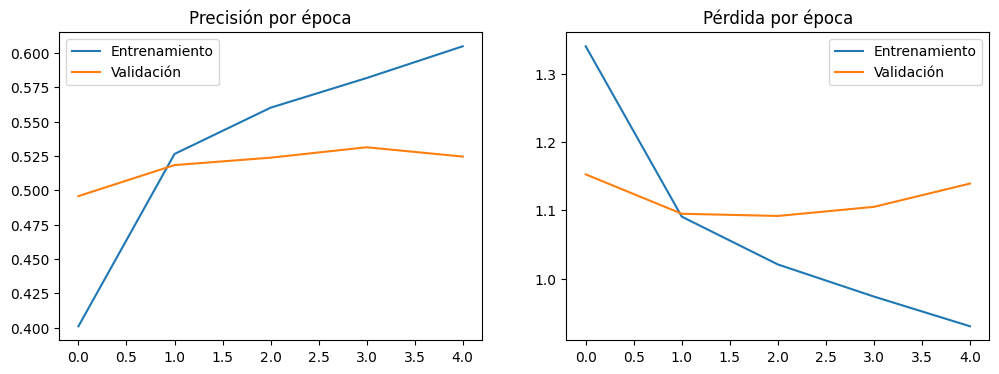

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


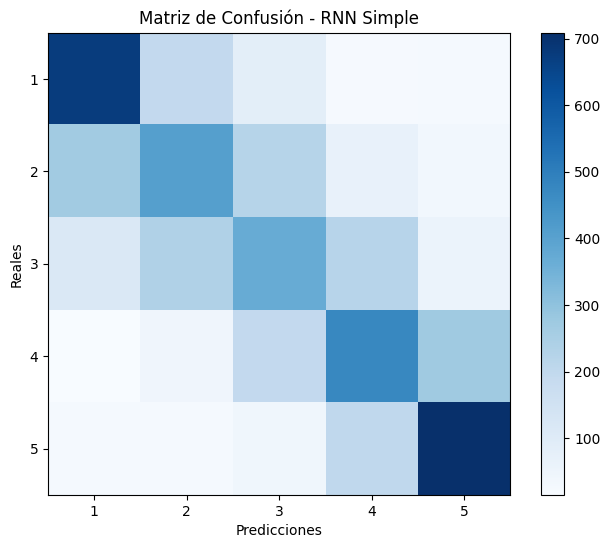

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model.predict([df_test_pad, df_test_lex]).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.61      0.67      0.64      1000
          2★       0.45      0.41      0.43      1000
          3★       0.41      0.37      0.39      1000
          4★       0.48      0.47      0.48      1000
          5★       0.65      0.71      0.68      1000

    accuracy                           0.53      5000
   macro avg       0.52      0.53      0.52      5000
weighted avg       0.52      0.53      0.52      5000



In [ ]:
y_pred = y_pred + 1
df_test['pred'] = y_pred
df_test.head(10)

review_body  stars split  pred
695                                Only used for a week      1  test     1
4825  They were beautiful and worked great for the a...      5  test     5
2377  We bought it in hopes my son would stop suckin...      3  test     3
2591   Cool bag with graphics, but smelled like mildew.      3  test     3
2358  Fine cups but you could probably buy these for...      3  test     2
3381                     Great value for a comfort shoe      4  test     4
2932  Beautiful rug and value however rolling it on ...      3  test     3
3664  It will help a lot driving there. It helps too...      4  test     5
2812  I had breast reduction surgery and this bra is...      3  test     3
2167  These do run large than expected. I wear a siz...      3  test     3

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e24bb6cba8c75f81883739516f8363e550f9d64b6fff4a07edb7d95658681e1d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime.lime_text import LimeTextExplainer
# Función de predicción para LIME
def predict_lime(texts):
    X_text, X_lex, _ = prepare_inputs(texts, tokenizer, maxlen) # Preparar el input
    return model.predict([X_text, X_lex]) # Passar inputs de texto y características léxicas al modelo

# Crear explicador
explainer = LimeTextExplainer(class_names=['1★', '2★', '3★', '4★', '5★'])

# Explicar una predicción
idx = 1  # Índice del ejemplo a explicar
exp = explainer.explain_instance(df_test.iloc[idx]['review_body'], predict_lime, num_features=10, top_labels=2)

# Mostrar explicación
exp.show_in_notebook(text=df_test.iloc[idx]['review_body'])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
#############################################
# Interpretación de Resultados por n-gramas#
#############################################

# Para interpretar, creamos un modelo auxiliar que extraiga los pesos de atención.
# Notar que la capa de atención está en la rama de texto.
attention_extractor = Model(inputs=[text_input, lex_input], outputs=att_weights)

def interpret_attention(example_text, lex_features):
    """
    Dado un texto (cadena) y sus características léxicas (vector),
    se obtiene la secuencia tokenizada, se extraen los pesos de atención
    y se muestra la asociación de cada token con su peso.
    Se agrupan tokens consecutivos de alta atención para inferir n-gramas.
    """
    # Prepara la entrada: tokenización y padding
    X_text, X_lex, _ = prepare_inputs([example_text], tokenizer, maxlen)
    # Extraer los pesos de atención (shape: (1, timesteps))
    att_w = attention_extractor.predict([X_text, X_lex])[0]

    # Obtener la secuencia de tokens (utilizando el tokenizer)
    # Se asume que tokenizer.index_word mapea índices a palabras.
    sequence = X_text[0]
    tokens = [tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0]

    # Recortar los pesos de atención a la longitud real (sin padding)
    att_w = att_w[:len(tokens)]

    # Mostrar tokens con sus pesos
    print("Token - Peso de Atención")
    for token, weight in zip(tokens, att_w):
        print(f"{token} - {weight:.4f}")

    # Agrupar tokens consecutivos con pesos altos (por ejemplo, mayor a un umbral)
    threshold = np.percentile(att_w, 75)  # usar el percentil 75 como umbral
    ngram = []
    ngrams = []
    for token, weight in zip(tokens, att_w):
        if weight >= threshold:
            ngram.append(token)
        else:
            if ngram:
                ngrams.append(" ".join(ngram))
                ngram = []
    if ngram:
        ngrams.append(" ".join(ngram))

    print("\nPosibles n-gramas característicos (tokens contiguos de alta atención):")
    for ng in ngrams:
        print(ng)

# Calcular las características léxicas para el ejemplo
example_lex = np.expand_dims(get_lex_features(df_test.iloc[idx]['review_body']), axis=0)
interpret_attention(df_test.iloc[idx]['review_body'], example_lex)

stars = df_test.iloc[idx]['stars']
print(f'\n Etiqueta real: {stars}')

stars_pred = df_test.iloc[idx]['pred']
print(f'\n Etiqueta predicha: {stars_pred}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Token - Peso de Atención
they - 0.0352
were - 0.0257
beautiful - 0.1280
and - 0.0648
worked - 0.0745
great - 0.1742
for - 0.0579
the - 0.0456
agape - 0.0740
items - 0.0439
i - 0.0305
needed - 0.0327
them - 0.0414
for - 0.0113

Posibles n-gramas característicos (tokens contiguos de alta atención):
beautiful
worked great
agape

 Etiqueta real: 5

 Etiqueta predicha: 5


## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dense

model_lstm_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa LSTM: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia para obtener una representación global.
    LSTM(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para resumir la información de toda la secuencia.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Transforma la representación agregada en probabilidades para cada clase.
    Dense(num_classes, activation='softmax')
])

model_lstm_pool.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

model_lstm_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Conexión entre teoría y práctica**

- LSTM con return_sequences=True:
        Teoría: Las LSTM están diseñadas para manejar dependencias a largo plazo mediante una celda de memoria y puertas que regulan el flujo de información.
        Práctica: Al configurar LSTM con return_sequences=True, obtenemos un estado oculto para cada paso de tiempo, lo que permite capturar la evolución de la información a lo largo de la secuencia.

- GlobalAveragePooling1D():
        Teoría: En lugar de depender únicamente del último estado (lo cual puede sesgar la información hacia el final de la secuencia), se puede aplicar una operación de pooling (en este caso, la media) a todos los estados ocultos.
        Práctica: GlobalAveragePooling1D() calcula el promedio de todos los estados ocultos, proporcionando una representación global y equilibrada de la secuencia, que se utiliza para la clasificación final.

- Capa de clasificación:
        Teoría: Una vez obtenida la representación global del texto, se utiliza una capa densa con softmax para transformar esa información en una distribución de probabilidad sobre las clases.
        Práctica: La capa final Dense con softmax genera la salida del modelo, permitiendo clasificar, por ejemplo, el sentimiento en 5 categorías.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_lstm_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.3173 - loss: 1.4853 - val_accuracy: 0.4800 - val_loss: 1.2215
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4730 - loss: 1.2214 - val_accuracy: 0.5032 - val_loss: 1.1501
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5304 - loss: 1.0827 - val_accuracy: 0.5180 - val_loss: 1.1165
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5602 - loss: 1.0219 - val_accuracy: 0.5220 - val_loss: 1.0988
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5839 - loss: 0.9725 - val_accuracy: 0.5258 - val_loss: 1.1033


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_lstm_pool.evaluate(df_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=('Tensor(shape=(None, 120))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5107 - loss: 1.1032

Precisión en test: 0.5220


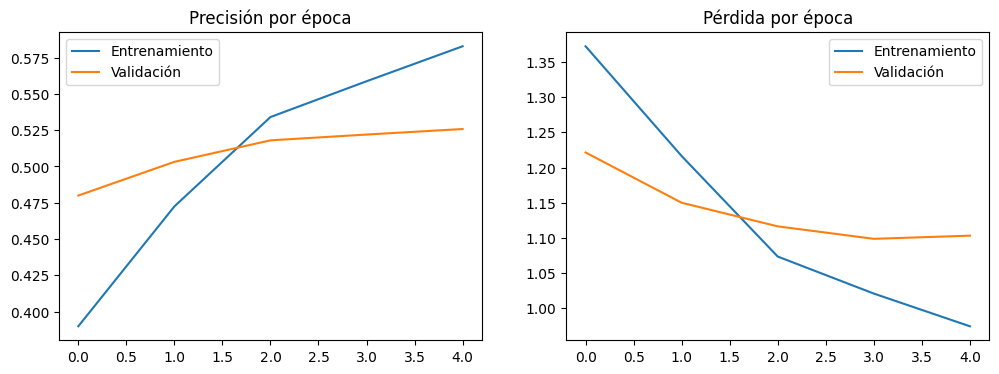

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


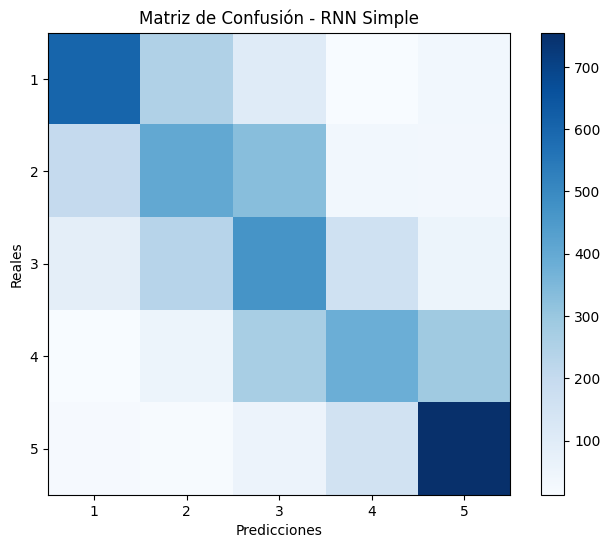

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_lstm_pool.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.66      0.60      0.63      1000
          2★       0.42      0.40      0.41      1000
          3★       0.38      0.47      0.42      1000
          4★       0.51      0.38      0.44      1000
          5★       0.65      0.76      0.70      1000

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



In [ ]:
from lime.lime_text import LimeTextExplainer
# Función de predicción para LIME
def predict_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return model_lstm_pool.predict(padded)

# Crear explicador
explainer = LimeTextExplainer(class_names=['1★', '2★', '3★', '4★', '5★'])

# Explicar una predicción
idx = 4  # Índice del ejemplo a explicar
exp = explainer.explain_instance(X_test[idx], predict_lime, num_features=10, top_labels=2)

# Mostrar explicación
exp.show_in_notebook(text=X_test[idx])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dense, Bidirectional

model_lstm_bi = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa Bidireccional LSTM: Procesa la secuencia completa en ambas direcciones (izquierda→derecha y derecha→izquierda).
    # Captura contexto anterior y posterior para cada palabra.
    # Luego, devuelve estados ocultos
    # Esto permite aplicar pooling a lo largo de la secuencia para obtener una representación global.
    Bidirectional(LSTM(128, return_sequences=True)),

    # Pooling: Calcula la media de los estados ocultos para resumir la información de toda la secuencia.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Transforma la representación agregada en probabilidades para cada clase.
    Dense(num_classes, activation='softmax')
])

model_lstm_bi.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

model_lstm_bi.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_lstm_bi.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.3129 - loss: 1.5022 - val_accuracy: 0.4658 - val_loss: 1.2265
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.4889 - loss: 1.1782 - val_accuracy: 0.4990 - val_loss: 1.1485
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5278 - loss: 1.0895 - val_accuracy: 0.5054 - val_loss: 1.1464
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5516 - loss: 1.0354 - val_accuracy: 0.5128 - val_loss: 1.1314
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.5814 - loss: 0.9773 - val_accuracy: 0.5214 - val_loss: 1.1306


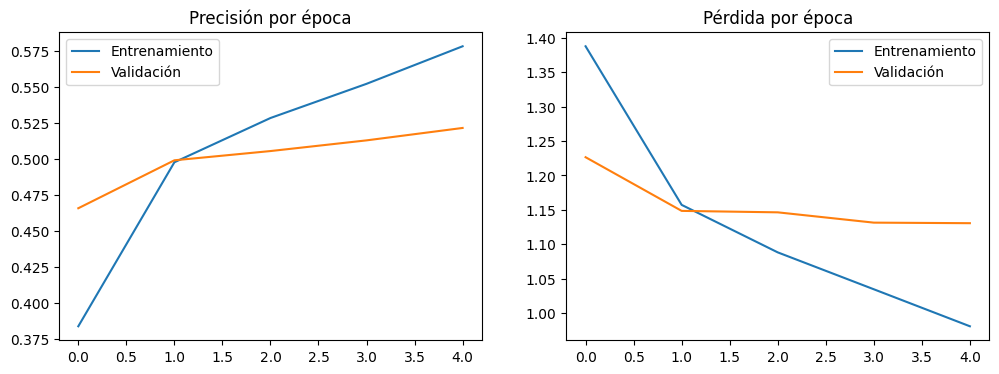

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


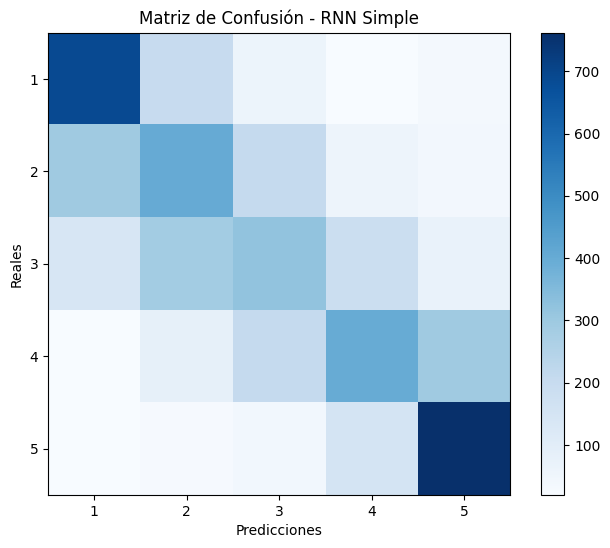

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión detallada
y_pred = model_lstm_bi.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=range(5), labels=range(1,6))
plt.yticks(ticks=range(5), labels=range(1,6))
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))

              precision    recall  f1-score   support

          1★       0.59      0.69      0.64      1000
          2★       0.40      0.40      0.40      1000
          3★       0.38      0.32      0.35      1000
          4★       0.49      0.40      0.44      1000
          5★       0.64      0.76      0.69      1000

    accuracy                           0.51      5000
   macro avg       0.50      0.51      0.50      5000
weighted avg       0.50      0.51      0.50      5000



> **TAREA: probar, si es posible, con las otras configuraciones de RNN y LSTM para ver si mejoran los resultados. Puedes, también, aumentar las épocas de los modelos básicos para ver si mejora el rendimiento.**

> **TAREA: probar los word embeddings de GloVe como característica adicional para ver si mejora el rendimiento de uno de los dos modelos básicos.**

> **TAREA: hacer análisis de sentimiento basado en aspectos con aprendizaje profundo reutilizando el cuaderno de aprendizaje automático tradicional.**